In [ ]:
!nvidia-smi
!pip install -q transformers accelerate bitsandbytes gradio peft

Tue Dec  9 22:36:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   30C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `ambiguous-question-generator` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate th

In [ ]:
import torch

print(f"GPU 사용 가능: {torch.cuda.is_available()}")
print(f"GPU 이름: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

GPU 사용 가능: True
GPU 이름: NVIDIA A100-SXM4-80GB


In [ ]:
# 모델 설정
CLASSIFY_BASE_MODEL = "microsoft/Phi-4-mini-reasoning"
CLASSIFY_LORA_ADAPTER = "jyering/classify-ambig"

QUESTION_GEN_BASE_MODEL = "microsoft/Phi-4-mini-reasoning"
QUESTION_GEN_LORA_ADAPTER = "Dayeoni/question-generator-dpo"

ANSWER_GEN_MODEL = "meta-llama/Llama-2-7b-chat-hf"

# 분류 모델 시스템 프롬프트
CLASSIFY_SYSTEM_PROMPT = """You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
 - If question is clear, set category=NONE and subclass=NONE
 - If question is ambiguous, classify category and subclass

Output format: category|subclass

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements
"""

# 질문 생성 모델 시스템 프롬프트
QUESTION_GEN_SYSTEM_PROMPT = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.

Output format: One clarifying question

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements"""

print("설정 완료")

설정 완료


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch


# 분류 모델
print("분류 모델 로딩 중...")
classify_tokenizer = AutoTokenizer.from_pretrained(
    CLASSIFY_BASE_MODEL,
    trust_remote_code=True
)

classify_base_model = AutoModelForCausalLM.from_pretrained(
    CLASSIFY_BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

classify_model = PeftModel.from_pretrained(
    classify_base_model,
    CLASSIFY_LORA_ADAPTER
)
classify_model = classify_model.merge_and_unload()
print("분류 모델 로드 완료\n")

# 질문 생성 모델
print("질문 생성 모델 로딩 중...")
question_gen_tokenizer = AutoTokenizer.from_pretrained(
    QUESTION_GEN_BASE_MODEL,
    trust_remote_code=True
)

question_gen_base_model = AutoModelForCausalLM.from_pretrained(
    QUESTION_GEN_BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

question_gen_model = PeftModel.from_pretrained(
    question_gen_base_model,
    QUESTION_GEN_LORA_ADAPTER
)
question_gen_model = question_gen_model.merge_and_unload()
print("질문 생성 모델 로드 완료\n")

# 답변 생성 모델
print("답변 생성 모델 로딩 중...")
answer_gen_tokenizer = AutoTokenizer.from_pretrained(ANSWER_GEN_MODEL)
answer_gen_model = AutoModelForCausalLM.from_pretrained(
    ANSWER_GEN_MODEL,
    torch_dtype=torch.float16,
    device_map="auto"
)
print("답변 생성 모델 로드 완료\n")

print(f"모든 모델 로드 완료 (GPU 메모리: {torch.cuda.memory_allocated() / 1024**3:.2f} GB)")

분류 모델 로딩 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

분류 모델 로드 완료

질문 생성 모델 로딩 중...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

질문 생성 모델 로드 완료

답변 생성 모델 로딩 중...


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

답변 생성 모델 로드 완료

모든 모델 로드 완료 (GPU 메모리: 26.85 GB)


In [ ]:
def classify_ambiguity(query):
    """분류 함수"""
    messages = [
        {"role": "system", "content": CLASSIFY_SYSTEM_PROMPT},
        {"role": "user", "content": query}
    ]

    input_ids = classify_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(classify_model.device)

    outputs = classify_model.generate(
        input_ids,
        max_new_tokens=50,
        do_sample=False,
        pad_token_id=classify_tokenizer.eos_token_id
    )

    response = classify_tokenizer.decode(
        outputs[0][input_ids.shape[1]:],
        skip_special_tokens=True
    )

    return response.strip()


def generate_clarifying_question(classification, query):
    """명확화 질문 생성"""
    user_input = f"[{classification}] {query}"

    messages = [
        {"role": "system", "content": QUESTION_GEN_SYSTEM_PROMPT},
        {"role": "user", "content": user_input}
    ]

    input_ids = question_gen_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(question_gen_model.device)

    outputs = question_gen_model.generate(
        input_ids,
        max_new_tokens=100,
        do_sample=False,
        pad_token_id=question_gen_tokenizer.eos_token_id
    )

    response = question_gen_tokenizer.decode(
        outputs[0][input_ids.shape[1]:],
        skip_special_tokens=True
    )

    return response.strip()


def generate_answer(query):
    """답변 생성"""
    messages = [{"role": "user", "content": query}]

    input_ids = answer_gen_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(answer_gen_model.device)

    outputs = answer_gen_model.generate(
        input_ids,
        max_new_tokens=200,
        do_sample=True,
        temperature=0.7,
        pad_token_id=answer_gen_tokenizer.eos_token_id
    )

    response = answer_gen_tokenizer.decode(
        outputs[0][input_ids.shape[1]:],
        skip_special_tokens=True
    )

    return response.strip()


def is_ambiguous(classification):
    """모호성 판단"""
    return "NONE" not in classification.upper()


print("추론 함수 정의 완료")

추론 함수 정의 완료


In [ ]:
def process_query(user_query):
    print(f"\n{'='*60}")
    print(f"입력: {user_query}")
    print(f"{'='*60}\n")

    classification = classify_ambiguity(user_query)
    print(f"분류 결과: {classification}")

    if not is_ambiguous(classification):
        print("라우팅: 답변 생성\n")
        output = generate_answer(user_query)
    else:
        print("라우팅: 명확화 질문 생성\n")
        output = generate_clarifying_question(classification, user_query)

    print(f"최종 답변: {output}\n")

    return {
        "분류 결과": classification,
        "출력": output
    }

print("파이프라인 함수 정의 완료")

파이프라인 함수 정의 완료


## Demo Interface

Gradio 기반 인터랙티브 데모입니다. 질문을 입력하면:
1. 모호성 분류 수행
2. 분류 결과에 따라 명확화 질문 또는 직접 답변 생성

In [ ]:
import gradio as gr

def gradio_interface(query):
    result = process_query(query)
    return (
        result["분류 결과"],
        result["출력"]
    )

demo = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(
        label="질문 입력",
        placeholder="예: Give me a list of good coffee shops?",
        lines=2
    ),
    outputs=[
        gr.Textbox(label="분류 결과"),
        gr.Textbox(label="최종 답변", lines=5)
    ],
    title="Ambiguous Query Handler",
    description="모호한 질문을 분류하고 명확화 질문 또는 답변을 생성합니다.",
    examples=[
        ["Give me a list of good coffee shops?"],
        ["What time does the store open?"],
        ["What is the capital of France?"],
    ]
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://624273b13b36c2a29c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 평가 데이터셋 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# 전처리된 데이터 로드
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data/claqua_integrated_test.json'

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    evaluation_data = json.load(f)

print(f"평가 데이터 로드 완료")
print(f"총 데이터 개수: {len(evaluation_data)}")
print(f"\n데이터 구조 확인:")
print(f"- 모호한 쿼리: {sum(1 for item in evaluation_data if item['is_ambiguous'] == 1)}개")
print(f"- 명확한 쿼리: {sum(1 for item in evaluation_data if item['is_ambiguous'] == 0)}개")

평가 데이터 로드 완료
총 데이터 개수: 1175

데이터 구조 확인:
- 모호한 쿼리: 503개
- 명확한 쿼리: 672개


In [ ]:
# 첫 번째 샘플 확인
print("\n샘플 데이터 (모호한 쿼리):")
ambiguous_sample = [item for item in evaluation_data if item['is_ambiguous'] == 1][0]
print(json.dumps(ambiguous_sample, indent=2, ensure_ascii=False))

print("\n샘플 데이터 (명확한 쿼리):")
clear_sample = [item for item in evaluation_data if item['is_ambiguous'] == 0][0]
print(json.dumps(clear_sample, indent=2, ensure_ascii=False))


샘플 데이터 (모호한 쿼리):
{
  "query": "What is Aldara's ingredient",
  "is_ambiguous": 1,
  "gold_clarification": "Which one do you mean, brand Aldara or non brand Aldara, when you say the active constituent?"
}

샘플 데이터 (명확한 쿼리):
{
  "query": "what is the musical composition that was recorded on Going Back to Cali?",
  "is_ambiguous": 0
}


### 파이프라인 테스트 실행

In [ ]:
def run_pipeline_with_metrics(query):
    """
    파이프라인 실행 및 메트릭 수집

    Returns:
        dict: 실행 결과 및 시간 메트릭
    """
    result = {
        'query': query,
        'classification': None,
        'is_routed_to_clarification': None,
        'output': None,
        'classification_time': 0,
        'generation_time': 0,
        'total_time': 0,
        'error': None
    }

    try:
        start_time = time.time()

        # Step 1: 분류
        classify_start = time.time()
        classification = classify_ambiguity(query)
        classify_end = time.time()
        result['classification'] = classification
        result['classification_time'] = classify_end - classify_start

        # Step 2: 라우팅 및 생성
        gen_start = time.time()
        if is_ambiguous(classification):
            result['is_routed_to_clarification'] = 1
            output = generate_clarifying_question(classification, query)
        else:
            result['is_routed_to_clarification'] = 0
            output = generate_answer(query)
        gen_end = time.time()

        result['output'] = output
        result['generation_time'] = gen_end - gen_start
        result['total_time'] = time.time() - start_time

    except Exception as e:
        result['error'] = str(e)

    return result

print("파이프라인 실행 함수 정의 완료")

파이프라인 실행 함수 정의 완료


In [ ]:
import random

# 테스트: 랜덤으로 15개 샘플링
print("테스트 실행: 랜덤으로 15개 쿼리 샘플링\n")

# 랜덤 시드 고정 (재현성)
random.seed(42)

# 모호한 쿼리와 명확한 쿼리 분리
ambiguous_data = [item for item in evaluation_data if item['is_ambiguous'] == 1]
clear_data = [item for item in evaluation_data if item['is_ambiguous'] == 0]

# 각각 랜덤 샘플링 (모호한 쿼리 10개, 명확한 쿼리 5개)
test_ambiguous = random.sample(ambiguous_data, 10)
test_clear = random.sample(clear_data, 5)

# 합치고 섞기
test_data = test_ambiguous + test_clear
random.shuffle(test_data)

print(f"샘플링 완료:")
print(f"  - 모호한 쿼리: 10개")
print(f"  - 명확한 쿼리: 5개")
print(f"  - 총: 15개\n")

results = []

for idx, item in enumerate(test_data):
    query = item['query']
    print(f"\n[{idx+1}/15] 처리 중: {query[:50]}...")

    # 파이프라인 실행
    pipeline_result = run_pipeline_with_metrics(query)

    # 결과 저장
    result_item = {
        'query': query,
        'ground_truth_is_ambiguous': item['is_ambiguous'],
        'ground_truth_clarification': item.get('gold_clarification', None),
        'predicted_classification': pipeline_result['classification'],
        'predicted_is_routed_to_clarification': pipeline_result['is_routed_to_clarification'],
        'predicted_output': pipeline_result['output'],
        'classification_time': pipeline_result['classification_time'],
        'generation_time': pipeline_result['generation_time'],
        'total_time': pipeline_result['total_time'],
        'error': pipeline_result['error']
    }

    results.append(result_item)

    print(f"  Ground Truth: {'모호함' if item['is_ambiguous'] == 1 else '명확함'}")
    print(f"  분류: {pipeline_result['classification']}")
    print(f"  라우팅: {'명확화 질문' if pipeline_result['is_routed_to_clarification'] == 1 else '답변 생성'}")
    print(f"  실행 시간: {pipeline_result['total_time']:.2f}초")

print("\n\n테스트 실행 완료")

테스트 실행: 랜덤으로 15개 쿼리 샘플링

샘플링 완료:
  - 모호한 쿼리: 10개
  - 명확한 쿼리: 5개
  - 총: 15개


[1/15] 처리 중: Who is the cover artist for The Secret Hour?...
  Ground Truth: 모호함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 6.72초

[2/15] 처리 중: who coauthored with Timothy Taylor?...
  Ground Truth: 명확함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 7.43초

[3/15] 처리 중: state the category of Sycorax?...
  Ground Truth: 명확함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 2.86초

[4/15] 처리 중: What type of award belongs to competition Season 1...
  Ground Truth: 모호함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 7.34초

[5/15] 처리 중: Who is Staying Alive's costume designer...
  Ground Truth: 모호함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 4.24초

[6/15] 처리 중: What literary series is Interesting Times...
  Ground Truth: 모호함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 7.39초

[7/15] 처리 중: What is the name of the fictional universe in whic...
  Ground Truth: 모호함
  분류: NONE|NONE
  라우팅: 답변 생성
  실행 시간: 6.77초

[8/15] 처리 중: what is Moustache's cause of death...
  Ground 

In [ ]:
# 상세 결과 확인 (생성된 출력 포함)
print("\n상세 결과:")
print("="*100)

for idx, result in enumerate(results, 1):
    print(f"\n[쿼리 {idx}]")
    print(f"Query: {result['query']}")
    print(f"Ground Truth: {'모호함' if result['ground_truth_is_ambiguous'] == 1 else '명확함'}")
    print(f"Predicted Routing: {'명확화 질문 생성' if result['predicted_is_routed_to_clarification'] == 1 else '답변 생성'}")
    print(f"Classification: {result['predicted_classification']}")
    print(f"\n생성된 출력:")
    print(f"  {result['predicted_output']}")

    if result['ground_truth_is_ambiguous'] == 1:
        print(f"\nGold Clarification:")
        print(f"  {result['ground_truth_clarification']}")

    print(f"\n실행 시간: {result['total_time']:.2f}초")
    print("="*100)


상세 결과:

[쿼리 1]
Query: Who is the cover artist for The Secret Hour?
Ground Truth: 모호함
Predicted Routing: 답변 생성
Classification: NONE|NONE

생성된 출력:
  The cover art for The Secret Hour, a young adult fantasy novel by Scott Westerfeld, was designed by the American illustrator and artist, Victor Martinez.

Victor Martinez is a talented artist and illustrator who has worked on a variety of book covers, including many other popular young adult novels. He is known for his unique and imaginative style, which often incorporates elements of fantasy, science fiction, and horror.

Martinez's cover art for The Secret Hour features a haunting and mysterious image of a young girl standing in a dark, misty forest, surrounded by strange and ominous symbols. The cover effectively captures the eerie and supernatural atmosphere of the novel, and has become a distinctive and memorable image in the world of young adult fantasy.

Gold Clarification:
  Do you mean non winning work The Secret Hour or winning wo

## 전체 테스트 데이터셋에 대한 파이프라인 실행

In [ ]:
import time
from tqdm import tqdm

print("=" * 100)
print("전체 데이터셋 평가 시작")
print("=" * 100)
print(f"\n총 데이터 개수: {len(evaluation_data)}")
print(f"  - 모호한 쿼리: {sum(1 for item in evaluation_data if item['is_ambiguous'] == 1)}개")
print(f"  - 명확한 쿼리: {sum(1 for item in evaluation_data if item['is_ambiguous'] == 0)}개")
print("\n평가 시작...\n")

# 결과 저장 리스트
all_results = []

# 시작 시간 기록
total_start_time = time.time()

# 전체 데이터셋에 대해 파이프라인 실행
for idx, item in enumerate(tqdm(evaluation_data, desc="평가 진행 중")):
    query = item['query']

    # 파이프라인 실행
    pipeline_result = run_pipeline_with_metrics(query)

    # 결과 저장
    result_item = {
        'query': query,
        'ground_truth_is_ambiguous': item['is_ambiguous'],
        'ground_truth_clarification': item.get('gold_clarification', None),
        'predicted_classification': pipeline_result['classification'],
        'predicted_is_routed_to_clarification': pipeline_result['is_routed_to_clarification'],
        'predicted_output': pipeline_result['output'],
        'classification_time': pipeline_result['classification_time'],
        'generation_time': pipeline_result['generation_time'],
        'total_time': pipeline_result['total_time'],
        'error': pipeline_result['error']
    }

    all_results.append(result_item)

    # 중간 저장 (100개마다)
    if (idx + 1) % 100 == 0:
        temp_df = pd.DataFrame(all_results)
        temp_df.to_csv(
            '/content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data/temp_full_results.csv',
            index=False,
            encoding='utf-8-sig'
        )

        elapsed_time = time.time() - total_start_time
        avg_time_per_query = elapsed_time / (idx + 1)
        remaining_queries = len(evaluation_data) - (idx + 1)
        estimated_remaining_time = remaining_queries * avg_time_per_query

        print(f"\n중간 저장 완료: {idx + 1}/{len(evaluation_data)} 처리됨")
        print(f"경과 시간: {elapsed_time/60:.1f}분")
        print(f"예상 남은 시간: {estimated_remaining_time/60:.1f}분")
        print(f"에러 발생: {sum(1 for r in all_results if r['error'] is not None)}개\n")

# 전체 소요 시간
total_elapsed_time = time.time() - total_start_time

print("\n" + "=" * 100)
print("평가 완료")
print("=" * 100)
print(f"총 처리 시간: {total_elapsed_time/60:.1f}분")
print(f"평균 처리 시간: {total_elapsed_time/len(evaluation_data):.2f}초/쿼리")
print(f"총 에러 발생: {sum(1 for r in all_results if r['error'] is not None)}개")

전체 데이터셋 평가 시작

총 데이터 개수: 1175
  - 모호한 쿼리: 503개
  - 명확한 쿼리: 672개

평가 시작...



평가 진행 중:   9%|▊         | 100/1175 [07:47<1:17:40,  4.34s/it]


중간 저장 완료: 100/1175 처리됨
경과 시간: 7.8분
예상 남은 시간: 83.7분
에러 발생: 0개



평가 진행 중:  17%|█▋        | 200/1175 [16:11<1:16:06,  4.68s/it]


중간 저장 완료: 200/1175 처리됨
경과 시간: 16.2분
예상 남은 시간: 78.9분
에러 발생: 0개



평가 진행 중:  26%|██▌       | 300/1175 [23:24<1:03:10,  4.33s/it]


중간 저장 완료: 300/1175 처리됨
경과 시간: 23.4분
예상 남은 시간: 68.3분
에러 발생: 0개



평가 진행 중:  34%|███▍      | 400/1175 [31:32<55:30,  4.30s/it]  


중간 저장 완료: 400/1175 처리됨
경과 시간: 31.5분
예상 남은 시간: 61.1분
에러 발생: 0개



평가 진행 중:  43%|████▎     | 500/1175 [39:39<1:04:21,  5.72s/it]


중간 저장 완료: 500/1175 처리됨
경과 시간: 39.7분
예상 남은 시간: 53.5분
에러 발생: 0개



평가 진행 중:  51%|█████     | 600/1175 [46:41<21:59,  2.29s/it]


중간 저장 완료: 600/1175 처리됨
경과 시간: 46.7분
예상 남은 시간: 44.7분
에러 발생: 0개



평가 진행 중:  60%|█████▉    | 700/1175 [55:06<30:49,  3.89s/it]


중간 저장 완료: 700/1175 처리됨
경과 시간: 55.1분
예상 남은 시간: 37.4분
에러 발생: 0개



평가 진행 중:  68%|██████▊   | 800/1175 [1:02:05<24:59,  4.00s/it]


중간 저장 완료: 800/1175 처리됨
경과 시간: 62.1분
예상 남은 시간: 29.1분
에러 발생: 0개



평가 진행 중:  77%|███████▋  | 900/1175 [1:09:20<19:02,  4.16s/it]


중간 저장 완료: 900/1175 처리됨
경과 시간: 69.3분
예상 남은 시간: 21.2분
에러 발생: 0개



평가 진행 중:  85%|████████▌ | 1000/1175 [1:16:10<11:48,  4.05s/it]


중간 저장 완료: 1000/1175 처리됨
경과 시간: 76.2분
예상 남은 시간: 13.3분
에러 발생: 0개



평가 진행 중:  94%|█████████▎| 1100/1175 [1:23:03<04:42,  3.77s/it]


중간 저장 완료: 1100/1175 처리됨
경과 시간: 83.1분
예상 남은 시간: 5.7분
에러 발생: 0개



평가 진행 중: 100%|██████████| 1175/1175 [1:28:21<00:00,  4.51s/it]


평가 완료
총 처리 시간: 88.4분
평균 처리 시간: 4.51초/쿼리
총 에러 발생: 0개


In [ ]:
# 최종 결과를 DataFrame으로 변환
results_df = pd.DataFrame(all_results)

# 기본 통계 출력
print("\n기본 통계:")
print(f"총 샘플 수: {len(results_df)}")
print(f"\n라우팅 결과:")
print(f"  - 명확화 질문 생성: {sum(results_df['predicted_is_routed_to_clarification'] == 1)}개")
print(f"  - 답변 생성: {sum(results_df['predicted_is_routed_to_clarification'] == 0)}개")
print(f"  - 에러: {sum(results_df['predicted_is_routed_to_clarification'].isna())}개")

print("\n분류 결과 분포:")
classification_counts = results_df['predicted_classification'].value_counts()
print(classification_counts.head(10))


기본 통계:
총 샘플 수: 1175

라우팅 결과:
  - 명확화 질문 생성: 308개
  - 답변 생성: 867개
  - 에러: 0개

분류 결과 분포:
predicted_classification
NONE|NONE    867
LA|LEX       161
AO|WHERE     103
AO|WHOM       22
AO|WHAT       20
LAISSA         1
LA|SEM         1
Name: count, dtype: int64


In [ ]:
# 결과 저장
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data'

# CSV 저장
csv_path = f'{OUTPUT_DIR}/full_evaluation_results.csv'
results_df.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"\nCSV 저장 완료: {csv_path}")

# JSON 저장 (더 상세한 정보 보존)
json_path = f'{OUTPUT_DIR}/full_evaluation_results.json'
results_df.to_json(json_path, orient='records', force_ascii=False, indent=2)
print(f"JSON 저장 완료: {json_path}")

# 요약 통계 저장
summary_stats = {
    'total_samples': len(results_df),
    'total_time': total_elapsed_time,
    'avg_time_per_query': total_elapsed_time / len(results_df),
    'errors': sum(results_df['error'].notna()),
    'routing_to_clarification': sum(results_df['predicted_is_routed_to_clarification'] == 1),
    'routing_to_answer': sum(results_df['predicted_is_routed_to_clarification'] == 0),
    'ground_truth_ambiguous': sum(results_df['ground_truth_is_ambiguous'] == 1),
    'ground_truth_clear': sum(results_df['ground_truth_is_ambiguous'] == 0),
}

summary_path = f'{OUTPUT_DIR}/evaluation_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)
print(f"요약 통계 저장 완료: {summary_path}")

print("\n모든 결과 저장 완료")


CSV 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data/full_evaluation_results.csv
JSON 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data/full_evaluation_results.json
요약 통계 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/evaluation_data/evaluation_summary.json

모든 결과 저장 완료!


In [ ]:
# 샘플 결과 확인 (처음 5개)
print("\n샘플 결과 확인 (처음 5개):")
print(results_df[['query', 'ground_truth_is_ambiguous', 'predicted_is_routed_to_clarification', 'total_time']].head().to_string(index=False))


샘플 결과 확인 (처음 5개):
                                          query  ground_truth_is_ambiguous  predicted_is_routed_to_clarification  total_time
                    What is Aldara's ingredient                          1                                     0    7.479389
                  The Comet's costume degisners                          1                                     1    0.209402
What is production company of The End of Summer                          1                                     0    3.601749
       State the type of release of Hello Dolly                          1                                     0    7.497658
          Name the album that consists Believer                          1                                     0    6.741696


# 평가

### 평가 1: 라우팅 정확도 및 F1 Score

In [ ]:
!pip install -q scikit-learn

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

def calculate_routing_metrics(results_df):
    y_true = results_df['ground_truth_is_ambiguous'].values
    y_pred = results_df['predicted_is_routed_to_clarification'].values

    valid_mask = ~results_df['predicted_is_routed_to_clarification'].isna()
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': int(tp),
        'fp': int(fp),
        'fn': int(fn),
        'tn': int(tn),
        'total': len(y_true)
    }

routing_metrics = calculate_routing_metrics(results_df)

print("="*80)
print("라우팅 정확도 및 F1 Score")
print("="*80)
print(f"\nRouting Accuracy: {routing_metrics['accuracy']:.4f}")
print(f"Precision: {routing_metrics['precision']:.4f}")
print(f"Recall: {routing_metrics['recall']:.4f}")
print(f"F1 Score: {routing_metrics['f1_score']:.4f}")

라우팅 정확도 및 F1 Score

Routing Accuracy: 0.4715
Precision: 0.3084
Recall: 0.1889
F1 Score: 0.2343


In [ ]:
confusion_df = pd.DataFrame({
    '실제: 명확함 (0)': [routing_metrics['tn'], routing_metrics['fp']],
    '실제: 모호함 (1)': [routing_metrics['fn'], routing_metrics['tp']]
}, index=['예측: 답변 생성 (0)', '예측: 명확화 질문 (1)'])

print("\n혼동 행렬:")
print(confusion_df)

print(f"\n상세:")
print(f"  TP (모호함 → 명확화 질문, 정답): {routing_metrics['tp']}")
print(f"  TN (명확함 → 답변 생성, 정답): {routing_metrics['tn']}")
print(f"  FP (명확함 → 명확화 질문, 불필요한 질문): {routing_metrics['fp']}")
print(f"  FN (모호함 → 답변 생성, 놓친 모호성): {routing_metrics['fn']}")
print(f"\n총 샘플: {routing_metrics['total']}")


혼동 행렬:
                실제: 명확함 (0)  실제: 모호함 (1)
예측: 답변 생성 (0)           459          408
예측: 명확화 질문 (1)          213           95

상세:
  TP (모호함 → 명확화 질문, 정답): 95
  TN (명확함 → 답변 생성, 정답): 459
  FP (명확함 → 명확화 질문, 불필요한 질문): 213
  FN (모호함 → 답변 생성, 놓친 모호성): 408

총 샘플: 1175


### 평가 2: CQ Score (명확화 질문 품질)

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model_similarity = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def calculate_cq_score(results_df):
    ambiguous_data = results_df[results_df['ground_truth_is_ambiguous'] == 1].copy()

    clarification_generated = ambiguous_data[
        (ambiguous_data['predicted_is_routed_to_clarification'] == 1) &
        (ambiguous_data['predicted_output'].notna()) &
        (ambiguous_data['predicted_output'].str.strip() != '')
    ]

    similarity_scores = []

    for _, row in clarification_generated.iterrows():
        pred_text = row['predicted_output'].strip()
        gold_text = row['ground_truth_clarification'].strip()

        if pred_text and gold_text:
            pred_embedding = model_similarity.encode(pred_text, convert_to_tensor=True)
            gold_embedding = model_similarity.encode(gold_text, convert_to_tensor=True)

            similarity = util.cos_sim(pred_embedding, gold_embedding).item()
            similarity_scores.append(max(0, min(1, similarity)))

    cq_score = np.mean(similarity_scores) if similarity_scores else 0.0

    return {
        'cq_score': cq_score,
        'similarity_scores': similarity_scores,
        'total_ambiguous': len(ambiguous_data),
        'generated_clarifications': len(clarification_generated),
        'valid_scores': len(similarity_scores)
    }

print("Semantic similarity 모델 로딩 중...")
cq_metrics = calculate_cq_score(results_df)

print("\n" + "="*80)
print("CQ Score (명확화 질문 품질)")
print("="*80)
print(f"\nCQ Score (평균 Semantic Similarity): {cq_metrics['cq_score']:.4f}")
print(f"\n총 모호한 쿼리: {cq_metrics['total_ambiguous']}개")
print(f"명확화 질문 생성: {cq_metrics['generated_clarifications']}개")
print(f"유효한 평가: {cq_metrics['valid_scores']}개")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Semantic similarity 모델 로딩 중...

CQ Score (명확화 질문 품질)

CQ Score (평균 Semantic Similarity): 0.4961

총 모호한 쿼리: 503개
명확화 질문 생성: 90개
유효한 평가: 90개


/tmp/ipython-input-4019192106.py:24: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4019192106.py:24: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4019192106.py:24: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4019192106.py:24: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/di

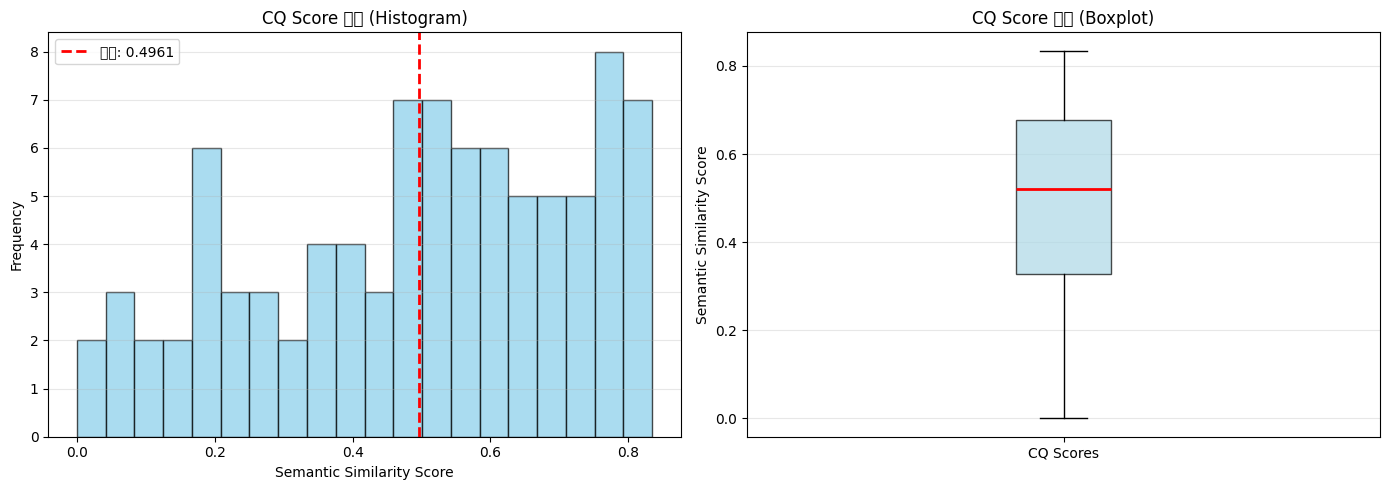


통계:
  최소값: 0.0000
  최대값: 0.8346
  중앙값: 0.5204
  표준편차: 0.2268


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scores = cq_metrics['similarity_scores']

axes[0].hist(scores, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(cq_metrics['cq_score'], color='red', linestyle='--', linewidth=2, label=f'평균: {cq_metrics["cq_score"]:.4f}')
axes[0].set_xlabel('Semantic Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('CQ Score 분포 (Histogram)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].boxplot(scores, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Semantic Similarity Score')
axes[1].set_title('CQ Score 분포 (Boxplot)')
axes[1].set_xticklabels(['CQ Scores'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n통계:")
print(f"  최소값: {np.min(scores):.4f}")
print(f"  최대값: {np.max(scores):.4f}")
print(f"  중앙값: {np.median(scores):.4f}")
print(f"  표준편차: {np.std(scores):.4f}")

In [ ]:
top_5 = sorted(zip(scores, range(len(scores))), reverse=True)[:5]
bottom_5 = sorted(zip(scores, range(len(scores))))[:5]

clarification_data = results_df[
    (results_df['ground_truth_is_ambiguous'] == 1) &
    (results_df['predicted_is_routed_to_clarification'] == 1) &
    (results_df['predicted_output'].notna()) &
    (results_df['predicted_output'].str.strip() != '')
].reset_index(drop=True)

print("\n" + "="*80)
print("가장 좋은 명확화 질문 (Top 5)")
print("="*80)
for score, idx in top_5:
    row = clarification_data.iloc[idx]
    print(f"\n[Score: {score:.4f}]")
    print(f"Query: {row['query']}")
    print(f"Generated: {row['predicted_output'][:100]}...")
    print(f"Gold: {row['ground_truth_clarification'][:100]}...")
    print("-"*80)

print("\n" + "="*80)
print("가장 낮은 명확화 질문 (Bottom 5)")
print("="*80)
for score, idx in bottom_5:
    row = clarification_data.iloc[idx]
    print(f"\n[Score: {score:.4f}]")
    print(f"Query: {row['query']}")
    print(f"Generated: {row['predicted_output'][:100]}...")
    print(f"Gold: {row['ground_truth_clarification'][:100]}...")
    print("-"*80)


가장 좋은 명확화 질문 (Top 5)

[Score: 0.8346]
Query: What is sport of Buffalo Bulls
Generated: Is the sport of Buffalo Bulls a team name or a type of game?...
Gold: Are you talking about the Buffalo Bulls baseball team or the Buffalo Bulls men's basketball team, wh...
--------------------------------------------------------------------------------

[Score: 0.8282]
Query: What is occupation of Robert Johansson?
Generated: What do you mean by "occupation" in the context of Robert Johansson?...
Gold: Do you mean politician Robert Johansson or actor Robert Johansson, when you ask the occupation?...
--------------------------------------------------------------------------------

[Score: 0.8269]
Query: A list of movies with Diane Peterson in them
Generated: What type of movies does Diane Peterson appear in?...
Gold: Are you referring to actor Diane Peterson or actress Diane Peterson, when you say the film that star...
--------------------------------------------------------------------------------

### 평가 3: 시스템 완료율

In [ ]:
def calculate_system_success_rate(results_df):
    total_samples = len(results_df)

    success_conditions = (
        (results_df['error'].isna()) &
        (results_df['predicted_output'].notna()) &
        (results_df['predicted_output'].str.strip() != '')
    )

    success_count = success_conditions.sum()
    success_rate = success_count / total_samples if total_samples > 0 else 0

    error_cases = results_df[results_df['error'].notna()]
    empty_output_cases = results_df[
        (results_df['error'].isna()) &
        ((results_df['predicted_output'].isna()) | (results_df['predicted_output'].str.strip() == ''))
    ]

    ambiguous_success = results_df[
        (results_df['ground_truth_is_ambiguous'] == 1) &
        success_conditions
    ]
    clear_success = results_df[
        (results_df['ground_truth_is_ambiguous'] == 0) &
        success_conditions
    ]

    total_ambiguous = len(results_df[results_df['ground_truth_is_ambiguous'] == 1])
    total_clear = len(results_df[results_df['ground_truth_is_ambiguous'] == 0])

    return {
        'success_rate': success_rate,
        'total_samples': total_samples,
        'success_count': success_count,
        'failure_count': total_samples - success_count,
        'error_cases': len(error_cases),
        'empty_output_cases': len(empty_output_cases),
        'ambiguous_success_rate': len(ambiguous_success) / total_ambiguous if total_ambiguous > 0 else 0,
        'clear_success_rate': len(clear_success) / total_clear if total_clear > 0 else 0,
        'ambiguous_success_count': len(ambiguous_success),
        'clear_success_count': len(clear_success),
        'total_ambiguous': total_ambiguous,
        'total_clear': total_clear
    }

system_metrics = calculate_system_success_rate(results_df)

print("="*80)
print("시스템 완료율")
print("="*80)
print(f"\nSystem Success Rate: {system_metrics['success_rate']:.4f} ({system_metrics['success_rate']*100:.2f}%)")
print(f"\n성공: {system_metrics['success_count']}개")
print(f"실패: {system_metrics['failure_count']}개")
print(f"총 샘플: {system_metrics['total_samples']}개")

시스템 완료율

System Success Rate: 0.9932 (99.32%)

성공: 1167개
실패: 8개
총 샘플: 1175개


In [ ]:
print("\n" + "="*80)
print("실패 케이스 분석")
print("="*80)
print(f"\n에러 발생: {system_metrics['error_cases']}개")
print(f"빈 응답: {system_metrics['empty_output_cases']}개")
print(f"총 실패: {system_metrics['failure_count']}개")

print("\n" + "="*80)
print("쿼리 유형별 완료율")
print("="*80)
print(f"\n모호한 쿼리:")
print(f"  성공: {system_metrics['ambiguous_success_count']}/{system_metrics['total_ambiguous']} ({system_metrics['ambiguous_success_rate']*100:.2f}%)")

print(f"\n명확한 쿼리:")
print(f"  성공: {system_metrics['clear_success_count']}/{system_metrics['total_clear']} ({system_metrics['clear_success_rate']*100:.2f}%)")


실패 케이스 분석

에러 발생: 0개
빈 응답: 8개
총 실패: 8개

쿼리 유형별 완료율

모호한 쿼리:
  성공: 498/503 (99.01%)

명확한 쿼리:
  성공: 669/672 (99.55%)


/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 53596 (\N{HANGUL SYLLABLE TEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 50756 (\N{HANGUL SYLLABLE WAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-901286595.py:26: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ip

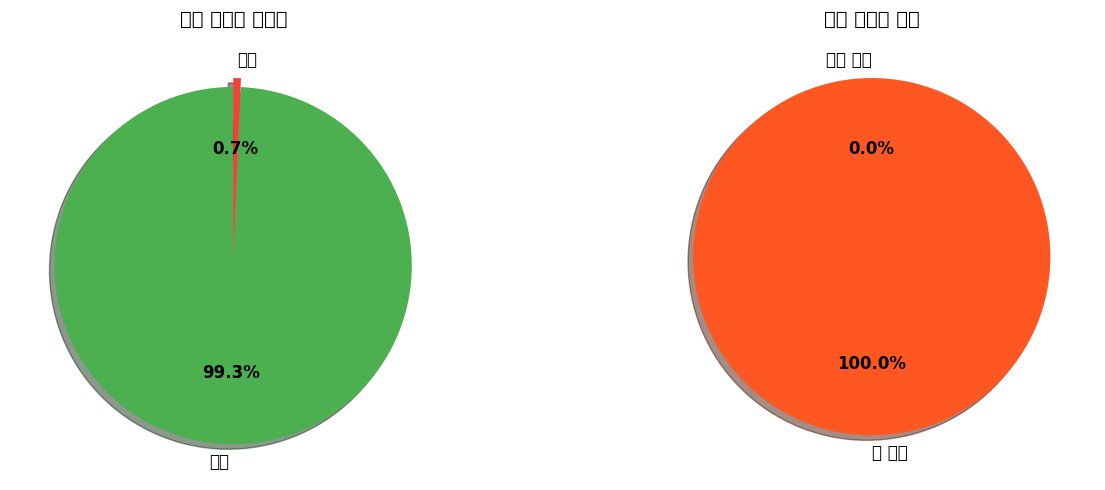

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = ['성공', '실패']
sizes = [system_metrics['success_count'], system_metrics['failure_count']]
colors = ['#4CAF50', '#F44336']
explode = (0.05, 0)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('전체 시스템 완료율', fontsize=14, weight='bold')

failure_labels = ['에러 발생', '빈 응답']
failure_sizes = [system_metrics['error_cases'], system_metrics['empty_output_cases']]
failure_colors = ['#FF9800', '#FF5722']

if sum(failure_sizes) > 0:
    axes[1].pie(failure_sizes, labels=failure_labels, colors=failure_colors, autopct='%1.1f%%',
                shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
    axes[1].set_title('실패 케이스 분포', fontsize=14, weight='bold')
else:
    axes[1].text(0.5, 0.5, '실패 케이스 없음', ha='center', va='center', fontsize=14)
    axes[1].set_title('실패 케이스 분포', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
failure_cases = results_df[
    (results_df['error'].notna()) |
    ((results_df['predicted_output'].isna()) | (results_df['predicted_output'].str.strip() == ''))
]

if len(failure_cases) > 0:
    print("\n" + "="*80)
    print(f"실패 케이스 샘플 (최대 10개)")
    print("="*80)

    for idx, row in failure_cases.head(10).iterrows():
        print(f"\n[샘플 {idx+1}]")
        print(f"Query: {row['query']}")
        print(f"Ground Truth: {'모호함' if row['ground_truth_is_ambiguous'] == 1 else '명확함'}")
        print(f"Predicted Routing: {'명확화 질문' if row['predicted_is_routed_to_clarification'] == 1 else '답변 생성'}")
        print(f"Error: {row['error'] if pd.notna(row['error']) else 'None'}")
        print(f"Output: '{row['predicted_output']}'")
        print("-"*80)
else:
    print("\n실패 케이스가 없습니다!")


실패 케이스 샘플 (최대 10개)

[샘플 2]
Query: The Comet's costume degisners
Ground Truth: 모호함
Predicted Routing: 명확화 질문
Error: None
Output: ''
--------------------------------------------------------------------------------

[샘플 36]
Query: What series does Burn Bright belong to
Ground Truth: 모호함
Predicted Routing: 명확화 질문
Error: None
Output: ''
--------------------------------------------------------------------------------

[샘플 429]
Query: What is Santa Marta's sport
Ground Truth: 모호함
Predicted Routing: 명확화 질문
Error: None
Output: ''
--------------------------------------------------------------------------------

[샘플 467]
Query: Weston Centre's contractors
Ground Truth: 모호함
Predicted Routing: 명확화 질문
Error: None
Output: ''
--------------------------------------------------------------------------------

[샘플 495]
Query: What are Lilith's species
Ground Truth: 모호함
Predicted Routing: 명확화 질문
Error: None
Output: ''
--------------------------------------------------------------------------------

[샘플 85

### 평가 4: 평균 완료 시간 (Latency)

In [ ]:
def calculate_latency_metrics(results_df):
    valid_data = results_df[results_df['error'].isna()].copy()

    ambiguous_data = valid_data[valid_data['ground_truth_is_ambiguous'] == 1]
    clear_data = valid_data[valid_data['ground_truth_is_ambiguous'] == 0]

    overall_latency = valid_data['total_time'].mean()
    ambiguous_latency = ambiguous_data['total_time'].mean() if len(ambiguous_data) > 0 else 0
    clear_latency = clear_data['total_time'].mean() if len(clear_data) > 0 else 0

    classification_time = valid_data['classification_time'].mean()
    generation_time = valid_data['generation_time'].mean()

    return {
        'overall_latency': overall_latency,
        'ambiguous_latency': ambiguous_latency,
        'clear_latency': clear_latency,
        'avg_classification_time': classification_time,
        'avg_generation_time': generation_time,
        'total_samples': len(valid_data),
        'ambiguous_samples': len(ambiguous_data),
        'clear_samples': len(clear_data),
        'classification_times': valid_data['classification_time'].values,
        'generation_times': valid_data['generation_time'].values,
        'total_times': valid_data['total_time'].values
    }

latency_metrics = calculate_latency_metrics(results_df)

print("="*80)
print("평균 완료 시간 (Latency)")
print("="*80)
print(f"\n전체 평균 Latency: {latency_metrics['overall_latency']:.4f}초")
print(f"\n쿼리 유형별:")
print(f"  모호한 쿼리 평균: {latency_metrics['ambiguous_latency']:.4f}초 (n={latency_metrics['ambiguous_samples']})")
print(f"  명확한 쿼리 평균: {latency_metrics['clear_latency']:.4f}초 (n={latency_metrics['clear_samples']})")

평균 완료 시간 (Latency)

전체 평균 Latency: 4.5110초

쿼리 유형별:
  모호한 쿼리 평균: 4.7682초 (n=503)
  명확한 쿼리 평균: 4.3184초 (n=672)


In [ ]:
print("\n" + "="*80)
print("파이프라인 단계별 실행 시간 (병목 구간 분석)")
print("="*80)
print(f"\n평균 분류 시간: {latency_metrics['avg_classification_time']:.4f}초")
print(f"평균 생성 시간: {latency_metrics['avg_generation_time']:.4f}초")

classification_ratio = latency_metrics['avg_classification_time'] / latency_metrics['overall_latency'] * 100
generation_ratio = latency_metrics['avg_generation_time'] / latency_metrics['overall_latency'] * 100

print(f"\n비율:")
print(f"  분류 단계: {classification_ratio:.1f}%")
print(f"  생성 단계: {generation_ratio:.1f}%")

if generation_ratio > 70:
    print("\n 생성 단계가 병목 구간입니다.")
elif classification_ratio > 50:
    print("\n 분류 단계가 병목 구간입니다.")
else:
    print("\n 파이프라인이 균형있게 분산되어 있습니다.")


파이프라인 단계별 실행 시간 (병목 구간 분석)

평균 분류 시간: 0.1623초
평균 생성 시간: 4.3487초

비율:
  분류 단계: 3.6%
  생성 단계: 96.4%

 생성 단계가 병목 구간입니다.


/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 50756 (\N{HANGUL SYLLABLE WAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2048886329.py:45: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


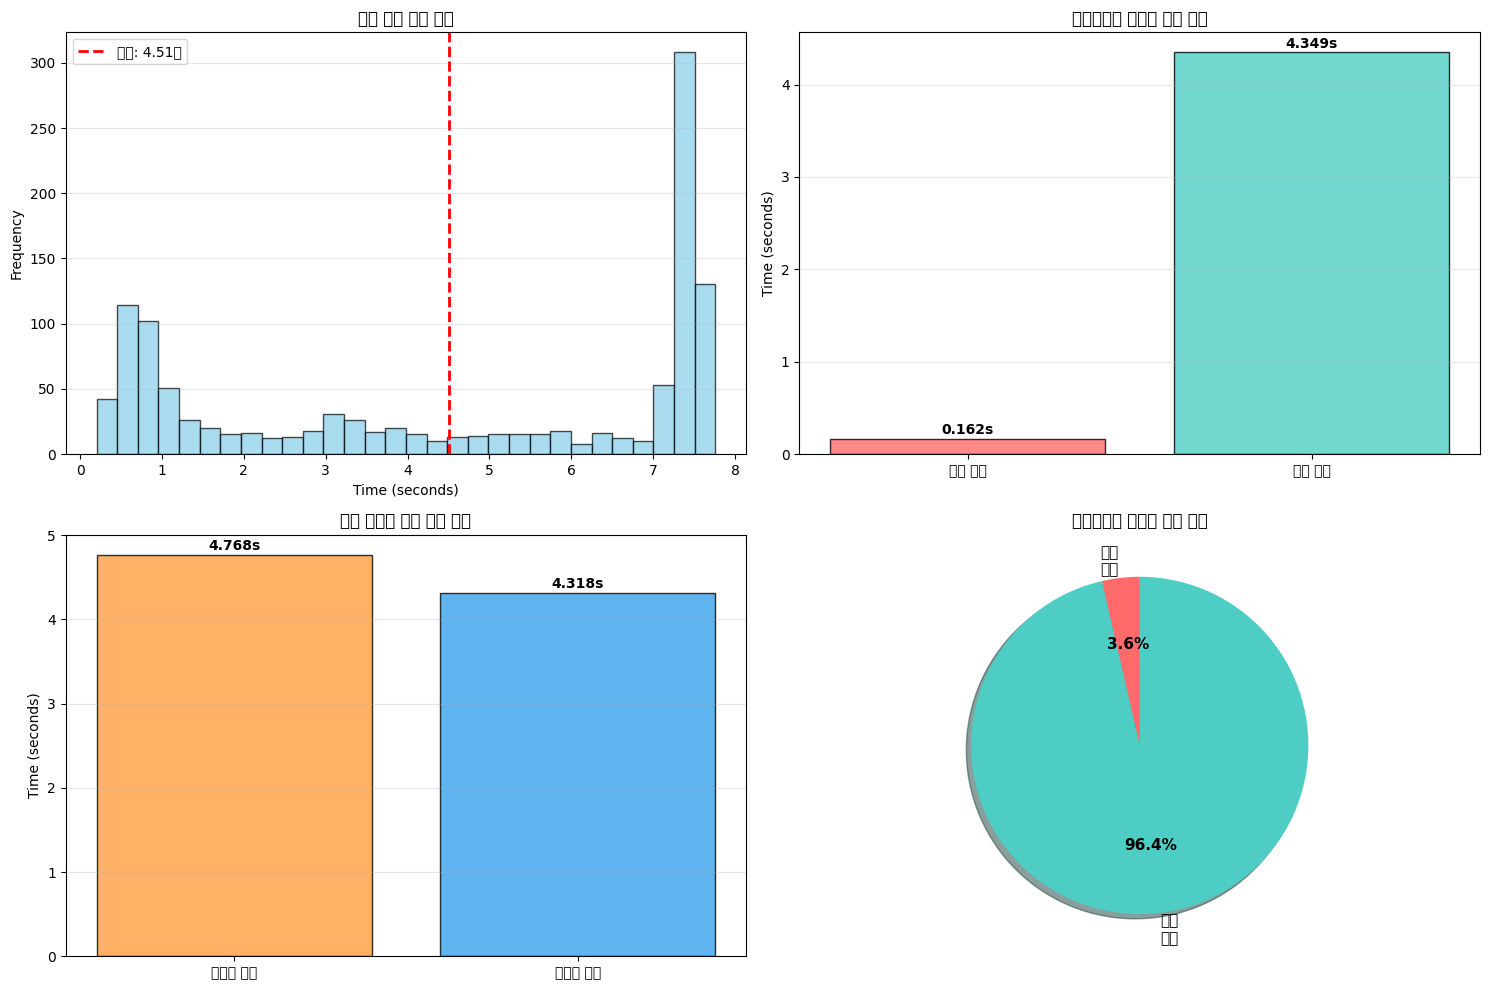

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(latency_metrics['total_times'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(latency_metrics['overall_latency'], color='red', linestyle='--', linewidth=2,
                   label=f'평균: {latency_metrics["overall_latency"]:.2f}초')
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('전체 완료 시간 분포')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

stages = ['분류 단계', '생성 단계']
times = [latency_metrics['avg_classification_time'], latency_metrics['avg_generation_time']]
colors_bar = ['#FF6B6B', '#4ECDC4']

axes[0, 1].bar(stages, times, color=colors_bar, edgecolor='black', alpha=0.8)
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].set_title('파이프라인 단계별 평균 시간')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(times):
    axes[0, 1].text(i, v + 0.05, f'{v:.3f}s', ha='center', fontweight='bold')

query_types = ['모호한 쿼리', '명확한 쿼리']
latencies = [latency_metrics['ambiguous_latency'], latency_metrics['clear_latency']]
colors_query = ['#FF9F40', '#36A2EB']

axes[1, 0].bar(query_types, latencies, color=colors_query, edgecolor='black', alpha=0.8)
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].set_title('쿼리 유형별 평균 완료 시간')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(latencies):
    axes[1, 0].text(i, v + 0.05, f'{v:.3f}s', ha='center', fontweight='bold')

stages_pie = ['분류\n단계', '생성\n단계']
times_pie = [latency_metrics['avg_classification_time'], latency_metrics['avg_generation_time']]
colors_pie = ['#FF6B6B', '#4ECDC4']

axes[1, 1].pie(times_pie, labels=stages_pie, colors=colors_pie, autopct='%1.1f%%',
               shadow=True, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1, 1].set_title('파이프라인 단계별 시간 비율')

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*80)
print("통계 요약")
print("="*80)

print(f"\n전체 시간:")
print(f"  최소: {np.min(latency_metrics['total_times']):.4f}초")
print(f"  최대: {np.max(latency_metrics['total_times']):.4f}초")
print(f"  중앙값: {np.median(latency_metrics['total_times']):.4f}초")
print(f"  표준편차: {np.std(latency_metrics['total_times']):.4f}초")

print(f"\n분류 시간:")
print(f"  최소: {np.min(latency_metrics['classification_times']):.4f}초")
print(f"  최대: {np.max(latency_metrics['classification_times']):.4f}초")
print(f"  중앙값: {np.median(latency_metrics['classification_times']):.4f}초")
print(f"  표준편차: {np.std(latency_metrics['classification_times']):.4f}초")

print(f"\n생성 시간:")
print(f"  최소: {np.min(latency_metrics['generation_times']):.4f}초")
print(f"  최대: {np.max(latency_metrics['generation_times']):.4f}초")
print(f"  중앙값: {np.median(latency_metrics['generation_times']):.4f}초")
print(f"  표준편차: {np.std(latency_metrics['generation_times']):.4f}초")


통계 요약

전체 시간:
  최소: 0.2011초
  최대: 7.7586초
  중앙값: 5.2064초
  표준편차: 2.8853초

분류 시간:
  최소: 0.1523초
  최대: 0.2093초
  중앙값: 0.1609초
  표준편차: 0.0066초

생성 시간:
  최소: 0.0440초
  최대: 7.5949초
  중앙값: 5.0476초
  표준편차: 2.8862초
